### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 5
### Due: Friday, Mar 7nd at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples (apologies, but did you mean steps here?) are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

In [12]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [6]:
# SETUP
import scipy
import numpy as np
import matplotlib
# more imports will happen as needed
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn
import corner
import emcee

Text(0.5, 1.0, 'Flux Data with Uncerts')

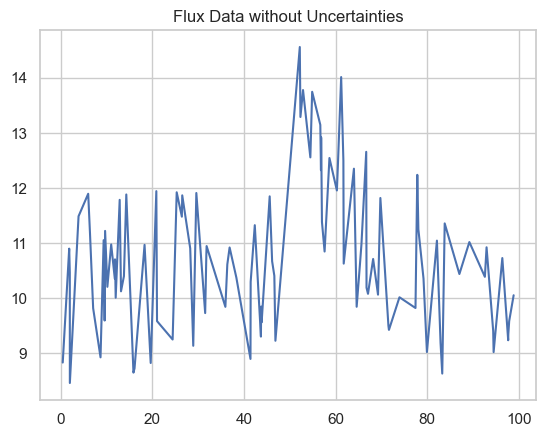

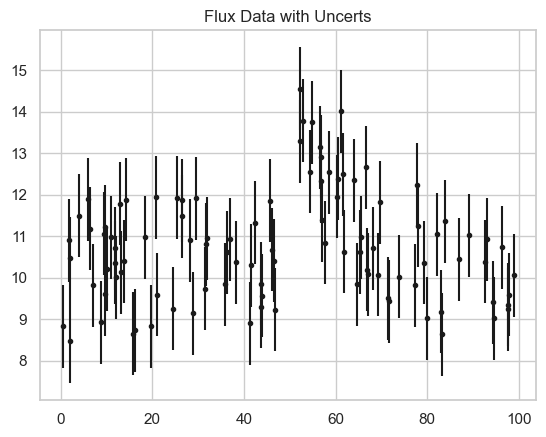

In [7]:
# PART 1
# read in and plots

# since I don't actually know what this data is, but I need a name that makes sense for future me, I'm just going to call it flux
flux_data_total = np.load("/Users/katiebarnhart/Documents/hw5_data_1.npy")

# im going to give myself some sort of idea of what the heck this stuff is
#print(flux_data_total[0])
#print(np.shape(flux_data_total)) 
# it is 100 data points, each with three aspects. neat

time_data = []
flux_data = []
uncerts = []
for i in flux_data_total:
    time_data.append(i[0])
    flux_data.append(i[1])
    uncerts.append(i[2]) #not strictly necessary b/c homoscedastic, but completeness. 

#print(time_data)
#print(flux_data) # these measurements have a LOTTA sig figs
time_data = np.array(time_data)
flux_data = np.array(flux_data)
uncerts = np.array(uncerts)

# this is NOT the only way to do this. Seaborn really prefers pandas DataFrames, which are basically 2d arrays where the data is stored
fig1 = plt.figure()
seaborn.set_theme(style='whitegrid')
seaborn.lineplot(x=time_data, y=flux_data)
plt.title("Flux Data without Uncertainties")

fig2 = plt.figure()
plt.errorbar(x=time_data, y=flux_data, yerr=uncerts, fmt=".k") #fmt is useful for nice-to-look-at plots 
plt.title("Flux Data with Uncerts") #fixed

In [49]:
# PART 2
# burst with exponential tail, above a noisy background
# time on the x-axis

def y_model(t, model_params):
    b, Amp, alpha, t_naught = model_params
    
    #b = nominal background amplitude. Amp = burst amplitude. 
    #alpha = controls how fast the burst dies off. t_naught = burst epoch

    print("Part 2 debug: t is WHAT? t is this:", t)
    #aight that's. um. thats not supposed to be that shape. 
    # this was the last piece of debugging that had a chance to happen before I unfortunately ran out of time. 
    if t < t_naught:
        y = b
    else: #for t >= t_naught
        y = b + Amp * exp(-alpha*(t-t_naught))

    return y

def Ln_Likelihood(model_params, t, y, uncertanties):
    Ln_model = y_model(t, model_params)
    return -0.5*np.sum(((y-Ln_model) / uncertanties)**2)

In [50]:
# PART 3
# I need a posterior, and a bunch of priors before I even get to the MCMC stuff

#log prior? I think its log prior
def Ln_prior_flux(model_params):
    b, Amp, alpha, t_naught = model_params
    Ln_alpha = np.log(alpha)
    if 0 <= b <= 50 and 0 <= Amp <= 50 and -5<=Ln_alpha<=5 and 0 <= t_naught < 100:
        return 1.0 #not sure if thats a reasonable choice for this or if these should all somehow have different numerical values
    else:
        return -np.inf # bc LN PRIOR omg

def flux_posterior(model_params, t, y, uncertanties):
    print(f"model_params: {model_params}, length: {len(model_params)}") # ChatGPT debugging
    #yeah this has the wrong shape. Took a while for ChatGPT to get there too. 
    if len(model_params) != 4:
        raise ValueError(f"Expected 4 parameters, got {len(model_params)}: {model_params}") #again, ChatGPT
    calc = Ln_prior_flux(model_params)
    calc2 = Ln_Likelihood(model_params, t, y, uncertanties)
    if calc == -np.inf:
        return calc
    else:
        return calc * calc2


# MCMC 
# From Lecture 11
ndim = 4
nwalkers = 32
nsteps = 5000

initial_guesses = np.array([25, 25, 1, 50]) + 1e-4*np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, flux_posterior, args=(time_data, flux_data, uncerts)) 

#print(np.shape(initial_guesses))
#print(nwalkers, ndim)

print(f"Shape of initial_guesses: {initial_guesses.shape}") #chatGPT debugging
sampler.run_mcmc(initial_guesses, nsteps) 
# currently this isn't working and im not sure why. 
# There is a value error somewhere, apparently Ln_prior_flux is getting too many arguments.
# Why? initial_guesses has the correct number of things in there. 
# stack overflow is not helpful


Shape of initial_guesses: (32, 4)
model_params: [24.99992537 25.00003384  1.00008384 49.99990082], length: 4
Part 2 debug: t is WHAT? t is this: [ 0.46954762  1.87898004  2.01075462  2.02183974  3.91877923  6.02254716
  6.41474963  7.10360582  8.71292997  9.39405108  9.60984079  9.71012758
 10.20448107 11.03751412 11.82744259 11.8727719  12.01965612 12.89262977
 13.17978624 13.81829513 14.33532874 15.89695836 16.13095179 18.3191362
 19.65823617 20.88767561 21.03825611 24.4425592  25.32916025 26.45556121
 26.53894909 28.28069626 28.94060929 29.61401975 31.54283509 31.79831794
 31.85689525 35.95079006 36.37107709 36.87251707 38.34415188 41.42629945
 41.466194   42.36547993 43.70319538 43.75872113 43.86015135 45.61503322
 46.14793623 46.63107729 46.86512016 52.18483218 52.32480535 52.88949198
 54.4883183  54.88135039 56.66014542 56.80445611 56.84339489 57.01967704
 57.59464956 58.65129348 60.27633761 60.48455197 61.20957227 61.69339969
 61.76354971 63.99210213 64.58941131 65.31083255 65.6

Traceback (most recent call last):
  File "/opt/anaconda3/envs/ASTR3300_pt1/lib/python3.12/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/_0/n4fgknn14j7c9wgk4lfg4kb40000gn/T/ipykernel_58337/3653819661.py", line 19, in flux_posterior
    calc2 = Ln_Likelihood(model_params, t, y, uncertanties)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/_0/n4fgknn14j7c9wgk4lfg4kb40000gn/T/ipykernel_58337/3483960645.py", line 22, in Ln_Likelihood
    Ln_model = y_model(t, model_params)
               ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/_0/n4fgknn14j7c9wgk4lfg4kb40000gn/T/ipykernel_58337/3483960645.py", line 14, in y_model
    if t < t_naught:
       ^^^^^^^^^^^^
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [27]:
# this cell is for me figuring things out
#tacos = np.random.random((nwalkers, ndim))
#print(tacos)

# print(flux_data_total)

The cells below were not run for reasons that should be clear. 

In [ ]:
# PART 4
# yEET the burn in period and thin the chain

# ALSO from Lecture 11
burn = 500
#emcee_trace = sampler.chain[:, burn:, :].reshape(-1, ndim)
# actually whoops no, nevermind, I think this doesn't slice like how we were asked. 
Auto_corr = sampler.get_autocorr_time(tol = 0)
emcee_trace = sampler.get_chain(discard=burn, thin=int(Auto_corr)) #https://emcee.readthedocs.io/en/stable/user/sampler/

# check chain length to see if we need to run for longer
print(type(emcee_trace))
print(len(emcee_trace)) # if this is short, then we can go back and adjust

In [ ]:
# PART 5
# corner plots of parameter space. 

corner_labels = [b, Amp, t_naught, Alpha]
corner.corner(emcee_trace, corner_labels, levels=(0.68, 0.95), quantiles=[0.16, 0.5, 0.84], show_title=True).T

In [ ]:
# PART 6
# yoink 100 samples from that chain

N_samples = 100
pull_range = len(emcee_trace) # should be an integer, but if it's not, then we can make it an int

random_emcee_samples = []
for j in range(100):
    index = np.random.randint(0, pull_range):
    random_emcee_samples.append(emcee_trace[index])

